In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os.path
from pathlib import Path
import time
import pandas as pd
import pickle as pkl
import librosa as lb

In [2]:
hop_sec = 512 * 1 / 22050
n_cores = 8
downsample = 1

In [3]:
ANNOTATIONS_ROOT_CLEAN = Path('/home/cchang/ttmp/raw_data/Chopin_Mazurkas/annotations_beat')
FEATURES_ROOT_CLEAN = Path('/home/cchang/ttmp/features/clean')

In [4]:
#times = np.array([5, 10, 15, 20, 25, 30])
times = [15]
#folder_names = ['dtw1', 'dtw2', 'dtw3', 'dtw4', 'subseqdtw', 'nwtw/gamma_0.346']

cfg_options = ['toy', 'small', 'medium', 'train_benchmark']
cfg = cfg_options[0] # Change this to appropriate benchmark

if cfg == 'toy':
    query_list = 'cfg_files/query.train_toy.list'
elif cfg == 'small':
    query_list = 'cfg_files/query.train_small.list'
elif cfg == 'medium':
    query_list = 'cfg_files/query.train_medium.list'
else:
    query_list = 'cfg_files/query.train.list'

## Alignment

In [5]:
def eval_dir(hypdir, querylist, hop_sec, scoring_collar = 0.1, annot_root_query = ANNOTATIONS_ROOT_CLEAN, \
             annot_root_ref = ANNOTATIONS_ROOT_CLEAN, features_query = FEATURES_ROOT_CLEAN, \
             features_ref = FEATURES_ROOT_CLEAN, savefile = None, verbose=False, partial_match=False, \
             algorithm = 'DTW', **kwargs):
    
    if savefile:
        outdir = os.path.dirname(savefile)
        outdir = Path(outdir)
        outdir.mkdir(parents=True, exist_ok=True)
    
    # Initialize dictionaries
    allErrs = {}
    allCosts = {}
    allAtrGT = {}
    
    cnt = 0
    if verbose:
        print(f'Processing {hypdir} ', end='')
        
    # assumes that if partial_match, the query dir has replacement_ts.csv file on the same level as annot_root_query
    if partial_match:
        
        assert('replacement_ts_file' in kwargs)
        
        df = pd.read_csv(kwargs['replacement_ts_file'])
        #df = pd.read_csv((annot_root_query.parent / 'replacement_ts.csv').as_posix())
        allTimestamps = df.set_index('name').to_dict(orient='index')
        
    with open(querylist, 'r') as f:
        for line in f:
            parts = line.strip().split()
            assert len(parts) == 2
            basename = os.path.basename(parts[0]) + '__' + os.path.basename(parts[1])
            hypfile = hypdir + '/' + basename + '.pkl'
            
            if not os.path.exists(hypfile):
                print("X", end='')
                continue
                
            if partial_match:
                downsample = 1

                times = allTimestamps[os.path.basename(parts[0]) + '.wav']
                firstRepEndIdx = times['beginning replacement end (idx)']
                midRepStartIdx = times['middle replacement start (idx)']
                midRepEndIdx = times['middle replacement end (idx)']
                lastRepStartIdx = times['ending replacement start (idx)']
                allErrs[basename] = eval_align_partial_matching(hypfile, hop_sec, firstRepEndIdx, midRepStartIdx, \
                                                                midRepEndIdx, lastRepStartIdx, scoring_collar, \
                                                                algorithm, downsample, annot_root_query, \
                                                                annot_root_ref, features_query, features_ref)
                
            else:
                allErrs[basename] = eval_file(hypfile, hop_sec, annot_root_ref, annot_root_query)
            cnt += 1
            if cnt % 500 == 0:
                print(".", end='')
                
    if verbose:
        print(' done')
    if savefile:
        
        if partial_match:
            pkl.dump([allErrs, allCosts, allAtrGT], open(savefile, 'wb'))
        else:
            pkl.dump(allErrs, open(savefile, 'wb'))
        
    return allErrs


In [6]:
def eval_align_partial_matching(hypfile, hop_sec, firstRepEndIdx, midRepStartIdx, midRepEndIdx, lastRepStartIdx, \
                                scoring_collar = 0.1, algorithm = 'DTW', downsample = 1, \
                                annot_query = ANNOTATIONS_ROOT_CLEAN, annot_ref = ANNOTATIONS_ROOT_CLEAN, \
                                features_query = FEATURES_ROOT_CLEAN, features_ref = FEATURES_ROOT_CLEAN):
    '''
    
    First file (query) = Tampered query
    Second file (ref) = clean reference
    
    '''
    
    parts = os.path.basename(hypfile).split('__')
    assert len(parts) == 2
    piece = extractPieceName(parts[0])
    
    annotfile_query = (annot_query / piece / parts[0]).with_suffix('.beat')
    annotfile_ref = (annot_ref / piece / parts[1]).with_suffix('.beat')
    
    featfile_query = (features_query / piece / parts[0]).with_suffix('.npy')
    featfile_ref = (features_ref / piece / parts[1]).with_suffix('.npy')
    
    gt_query, gt_ref = getTimestamps(annotfile_query), getTimestamps(annotfile_ref)
        
    hypalign = loadAlignment(hypfile) # warping path in frames
    
    if hypalign is None:
        gt_attribution = []
    else:
        
        # Alignment Error
        if algorithm == 'HPTW':  # for HPTW, hypalign is in the form [visible path, hidden path]
            err = getAlignmentError(gt_query, gt_ref, hop_sec, firstRepEndIdx, midRepStartIdx, midRepEndIdx, lastRepStartIdx, hypalign[0], scoring_collar)
        else:
            err = getAlignmentError(gt_query, gt_ref, hop_sec, firstRepEndIdx, midRepStartIdx, midRepEndIdx, lastRepStartIdx, hypalign, scoring_collar)
        
#         # Attribution Cost
#         hop_frames = hop_sec * 22050
                
#         frame_cost, gt_attribution = getAttributionCost(featfile_query, featfile_ref, hop_frames, firstRepEndIdx, midRepStartIdx, midRepEndIdx, lastRepStartIdx, hypalign, algorithm = algorithm, hidden_path = None, downsample = 1)
        
#         frame_cost = []
#         gt_attribution = []
        
    return err

In [22]:
def getAlignmentError(gt_query, gt_ref, hop_sec, firstRepEndIdx, midRepStartIdx, midRepEndIdx, lastRepStartIdx, \
                      hypalign, scoring_collar = 0.1, sr = 22050):
    '''
    Computes alignment error on untampered regions
    
    Inputs:
    gt_query: ground truth ts of query beats in seconds
    gt_ref: ground truth ts of reference beats in seconds
    hop_sec: hop size in seconds
    firstRepEndIdx: ending idx of first replacement section
    midRepStartIdx: starting idx of middle replacement section
    midRepEndIdx: ending idx of middle replacement section
    lastRepStartIdx: starting idx of last replacement section
    hypalign: predicted warping path
    
    Outputs:
    err: error in seconds between prediction and ground truth
    
    '''
    # hypalign[:,0] corresponds to query audio
    # hypalign[:,1] corresponds to ref audio
    
    scoring_collar_frames = scoring_collar * sr
    
    # Get indices to exclude from gt_query 
    startExclude = np.argwhere(gt_query * sr < firstRepEndIdx + scoring_collar_frames)
    midExclude = np.argwhere(np.logical_and(gt_query * sr > midRepStartIdx - scoring_collar_frames, \
                                            gt_query * sr < midRepEndIdx + scoring_collar_frames))
    endExclude = np.argwhere(gt_query * sr > lastRepStartIdx - scoring_collar_frames)

    excludedIdx = np.concatenate((startExclude, midExclude, endExclude)).flatten()
    keepIdx = np.setdiff1d(np.arange(len(gt_query)), excludedIdx)
    
    gt_query_valid = gt_query[keepIdx]

    # Calculate predictions via interpolation only on valid frames in query
    pred_ref = np.interp(gt_query_valid, hypalign['wp'][:,0]*hop_sec, hypalign['wp'][:,1]*hop_sec)

    # Calculate error
    err = pred_ref - gt_ref[keepIdx]
    
    return err

In [23]:
def getTimestamps(annotfile):
    df = pd.read_csv(annotfile, header=None, sep='\s+', skiprows=3)
    return np.array(df[0])


def extractPieceName(fullpath):
    basename = os.path.basename(fullpath) # e.g. Chopin_Op068No3_Sztompka-1959_pid9170b-21
    parts = basename.split('_')
    piece = '_'.join(parts[0:2]) # e.g. Chopin_Op068No3
    return piece

def loadAlignment(hypfile):
    with open(hypfile, 'rb') as f:
        d = pkl.load(f)
    return d


In [24]:
# *** Edit these 2 lines as we add more systems ****
savefile_names = ['dtw223.pkl']
folder_names = ['dtw223']
# **************************************************
for t in times:

    EXPERIMENTS_ROOT = '/home/tshaw/ttmp/partial_match/%s/experiments/align_clean_to_%ss' % (cfg, t)
    EVALUATIONS_ROOT = '/home/tshaw/ttmp/partial_match/%s/evaluations/alignment/align_clean_to_%ss' % (cfg, t)
#     query = Path('/home/cchang/ttmp/raw_data/partial_match/Chopin_Mazurkas_partial_match_%ss/annotations_beat' % t)
    ts = '/home/cchang/ttmp/raw_data/partial_match/Chopin_Mazurkas_partial_match_%ss/replacement_ts.csv' % t
    
    for i in range(len(savefile_names)): #range(6) is normal, skipping 0 since we've already calculated that
        savefile = EVALUATIONS_ROOT + "/" + savefile_names[i]
        hypdir = EXPERIMENTS_ROOT + "/" + folder_names[i]
        print(hypdir)

        start = time.time()
#         if i == 5: # =5 if regular
#             all_errors_test, allCosts, allAtrGT = eval_dir(hypdir, query_list, hop_sec, savefile = savefile, partial_match=True, replacement_ts_file=ts, algorithm='NWTW')
#         else:
        all_errors_test = eval_dir(hypdir, query_list, hop_sec, savefile = savefile, partial_match=True, replacement_ts_file=ts)
        print('Took ', time.time() - start)

/home/tshaw/ttmp/partial_match/toy/experiments/align_clean_to_15s/dtw223
Took  0.06461668014526367


### Alignment Figures

In [25]:
def calc_error_rates(errFile, maxTol, justErrorFile = False):
    
    # read from file
    with open(errFile, 'rb') as f:
        if justErrorFile:
            allErrs = pkl.load(f)
        else:
            allErrs, _, _ = pkl.load(f)
    
    # collect all errors
    errsFlat = []
    for query in allErrs:
        if allErrs[query] is not None:
            errs = np.array(allErrs[query])
            errsFlat.append(errs)
    errsFlat = np.concatenate(errsFlat)
    
    # calculate error rates
    errRates = np.zeros(maxTol+1)
    for i in range(maxTol+1):
        errRates[i] = np.mean(np.abs(errsFlat) > i/1000)
    
    return errRates, errsFlat

In [26]:
allErrors = []

for t in times:

    EVALUATIONS_ROOT = '/home/tshaw/ttmp/partial_match/%s/evaluations/alignment/align_clean_to_%ss' % (cfg, t)

    error_rate_tests = []

    for i in range(len(savefile_names)): # 6 in normal timesb
        savefile = EVALUATIONS_ROOT + "/" + savefile_names[i]
        print(savefile)
        error_rate_tests.append(calc_error_rates(savefile, 1000)[0])
#         err = calc_error_rates(savefile, 1000)[0]

    allErrors.append(error_rate_tests)

/home/tshaw/ttmp/partial_match/toy/evaluations/alignment/align_clean_to_15s/dtw223.pkl


In [27]:
# allErrors[timeIdx][systemIdx]
allErrors[0][0]

array([1.        , 0.97191011, 0.94171348, ..., 0.09550562, 0.09550562,
       0.09550562])

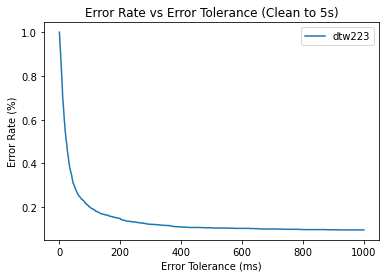

In [28]:
for curve in allErrors[0]:
    plt.plot(curve)

plt.xlabel('Error Tolerance (ms)')
plt.ylabel('Error Rate (%)')
plt.legend(folder_names)
plt.title('Error Rate vs Error Tolerance (Clean to 5s)')
plt.show()

## TODO: 3 Pane Bar Graph

## Attribution

In [163]:
def eval_attribution(hypdir, query_list, hop_sec, annot_file, \
                     savefile = None, scoring_collar = 0.1, numThresholds = 1000, sr = 22050):
    '''
    Evaluate the attribution task
    '''
    scoring_collar_frames = scoring_collar * sr
    
    df = pd.read_csv(annot_file)
    allTimestamps = df.set_index('name').to_dict(orient='index')
    attributions = []
    
    with open(query_list, 'r') as f:
        for line in f:
            parts = line.strip().split()
            assert len(parts) == 2
            basename = os.path.basename(parts[0]) + '__' + os.path.basename(parts[1])
            hypfile = hypdir + '/' + basename + '.pkl'
            
            if not os.path.exists(hypfile):
                print("X", end='')
                continue
                
            hypalign = pkl.load(open(hypfile, 'rb'))
            path = hypalign['wp']

            times = allTimestamps[os.path.basename(parts[0]) + ".wav"]
            
            firstRepEndTime = times['beginning replacement end (idx)'] / sr
            midRepStartTime = times['middle replacement start (idx)'] / sr
            midRepEndTime = times['middle replacement end (idx)'] / sr
            lastRepStartTime = times['ending replacement start (idx)'] / sr
            boundaries = [firstRepEndTime, midRepStartTime, midRepEndTime, lastRepStartTime]
            
            gt = getAttributionGT(path, boundaries, scoring_collar, hop_sec)
            
            # Impute cost scores
            # Interpolate here to fill in the frames that the path jumps over
            costs = np.interp(np.arange(path[-1,0]), path[:,0], hypalign["costs"])
            
            for i in range(gt.shape[0]):
                if gt[i] >=0:
                    attributions.append([gt[i], costs[i]])
                    
    attributions = np.array(attributions)
    ROC = calc_ROC(attributions, numThresholds)
    
    if savefile is not None:
        outdir = os.path.dirname(savefile)
        outdir = Path(outdir)
        outdir.mkdir(parents=True, exist_ok=True)
        pkl.dump(ROC, open(savefile, 'wb'))

    return ROC

In [164]:
def getAttributionGT(path, boundaries, scoring_collar, hop_sec):
    
    query_length = path[-1,0] # NOTE: Make sure this is the correct index to get the length of the query piece
    gt = np.zeros(query_length)
    
    # Get the GT for each frame
    # For now, just represent each frame with a single timestamp (at where the frame begins)
    for frame in range(query_length):
        t_query = frame * hop_sec
        if withinCollar(t_query, boundaries, scoring_collar):
            gt[frame] = -1
        elif t_query < boundaries[0] or (t_query > boundaries[1] and t_query < boundaries[2]) or t_query > boundaries[3]:
            gt[frame] = 1
        else:
            gt[frame] = 0
            
    return gt

In [165]:
def withinCollar(t_query, boundaries, scoring_collar):
    for t_boundary in boundaries:
        if np.abs(t_query - t_boundary) < scoring_collar:
            return True
    return False

In [166]:
def calc_ROC(attributions, numThresholds):
    '''
    Calculates ROC curve for attributions based on number of thresholds
    
    '''
    
    costs = attributions[:,1]
    gt = attributions[:,0]
        
        
    # Get minimum and max for thresholds
    thresholdMin = np.min(costs)
    thresholdMax = np.max(costs)
    
    thresholds = np.linspace(thresholdMin, thresholdMax, numThresholds)
    ROC = np.ones((numThresholds,3))*-1
    
    # For each threshold, calculate false positive and false negative (miss) rate
    for i, threshold in enumerate(thresholds):
        FPCountTot = 0
        FNCountTot = 0
        TrueNegCount = 0
        TruePosCount = 0
        
        FPCount, FNCount = calcFPFN(costs, gt, threshold)

        TrueNegCount += np.sum(gt == 0)
        TruePosCount += np.sum(gt == 1)

        FPCountTot += FPCount
        FNCountTot += FNCount
        
        # Threshold, False Positive, False Negative
        ROC[i,:] = [threshold, FPCountTot/TrueNegCount, FNCountTot/TruePosCount]
    
    return ROC

In [167]:
def calcFPFN(costVec, gtAttribution, threshold):
    '''
    Calculate number of false positives and false negatives
    '''
    
    # If cost is lower than threshold, then we consider sample in
    # non tampered region (nontampered = 1, tampered = 0)
    costHypVec = (costVec < threshold).astype(int)

    diffVec = (costHypVec - gtAttribution)

    FPCount = np.sum(np.maximum(diffVec,0))
    FNCount = np.sum(np.minimum(diffVec,0))*-1

    return FPCount, FNCount

In [168]:
ROCCurves = []
for t in times:
    EXPERIMENTS_ROOT = '/home/tshaw/ttmp/partial_match/%s/experiments/align_clean_to_%ss' % (cfg, t)
    EVALUATIONS_ROOT = '/home/tshaw/ttmp/partial_match/%s/evaluations/attribution/align_clean_to_%ss' % (cfg, t)

    ts = '/home/cchang/ttmp/raw_data/partial_match/Chopin_Mazurkas_partial_match_%ss/replacement_ts.csv' % t
    for i in range(len(savefile_names)): #range(6) is normal, skipping 0 since we've already calculated that
        savefile = EVALUATIONS_ROOT + "/" + savefile_names[i]
        hypdir = EXPERIMENTS_ROOT + "/" + folder_names[i]
        print(hypdir)

        start = time.time()
        ROC = eval_attribution(hypdir, query_list, hop_sec, ts, savefile = savefile, scoring_collar = 0.1)
        ROCCurves.append(ROC)
        print('Took ', time.time() - start)

/home/tshaw/ttmp/partial_match/toy/experiments/align_clean_to_15s/dtw223
Took  0.6584782600402832


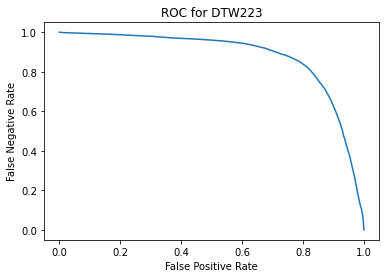

In [169]:
ROC = ROCCurves[0]
plt.plot(ROC[:,1], ROC[:,2])
plt.xlabel("False Positive Rate");
plt.ylabel("False Negative Rate");
plt.title("ROC for DTW223");

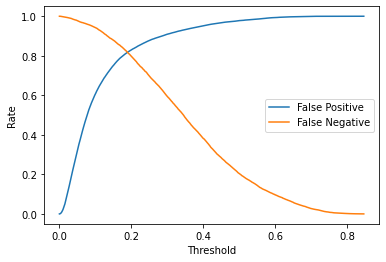

In [170]:
plt.plot(ROC[:,0], ROC[:,1]);
plt.plot(ROC[:,0], ROC[:,2]);
plt.xlabel("Threshold");
plt.ylabel("Rate")
plt.legend(["False Positive", "False Negative"]);

### Figures

# TODO: Attribution Figure